In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qecsim.graphtools import blossom5
from pymatching import Matching


## Error threshold calculation (star stabilizers)


In [815]:
Nrep = 1000 # number of iterations
L_list = [6,8,10]
prob_l = 0.05 # loss rate
pz_list = np.linspace(0.06,0.1,10)
fail_prob_z = np.zeros((len(L_list),len(pz_list)))

for i_L, r in enumerate(L_list):
    print("L= ", r)
    l = 2 # number of sublattice points (2 for toric code) or primal/dual
#     r = 5 # number of columns
    r1 = r # number of rows
    r2 = r # number of rows

  # star stabilzers
    Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
    for i_y in range(r2):
        for i_x in range(r1):
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1


    for i_p, prob_z in enumerate(pz_list):
        for i_n in range(Nrep):
               # # loss error
            error_loss = np.random.rand(l*r1*r2) 
            loss_inds = np.argwhere(error_loss < prob_l)[:,0]
            remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
            error_loss[loss_inds] = 1
            error_loss[remain_inds] = 0
            
            Sx_new = []
            inds_new = []
            Sx_old = np.copy(Sx)
            inds_old = list(range(r1*r2))
            for loss_index in loss_inds:
                st_ind = np.argwhere(Sx_old[:,loss_index]>0)
                st_ind = list(st_ind[:,0])
                if len(st_ind)==2:
                    inds_new.append(st_ind)
                    Stot = np.zeros(l*r1*r2)
                    for i_remove in st_ind:
                        inds_old.remove(i_remove)
                        Stot += Sx_old[i_remove,:]
                    Sx_new.append(list(Stot%2)) 
                    Sx_old[st_ind,:] = 0
                elif len(st_ind)==1:
                    st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
                    inds_new[st_new_ind][:] += st_ind
                    inds_old.remove(st_ind[0])
                    Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
                    Sx_old[st_ind,:] = 0
                else:
                    st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
                    if len(st_new_ind)>1:
                        st_new_ind = list(st_new_ind[:,0])
                        inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                        Stot = np.zeros(l*r1*r2)
                        for i_remove in st_new_ind:
                            Stot += np.array(Sx_new)[i_remove,:]        
                        Sx_new[st_new_ind[0]] = list(Stot%2)
                        del inds_new[st_new_ind[1]]
                        del Sx_new[st_new_ind[1]]
            Sx_new = np.array(Sx_new, dtype=int)
            for loss_index in loss_inds:
                st_ind = np.argwhere(Sx_old[:,loss_index]>0)
                st_new_ind = np.argwhere(Sx_old[:,loss_index]>0)
                assert len(st_ind)+len(st_new_ind)==0

            num_Sx_red = len(inds_new)+len(inds_old)
            Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
            Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
            if len(inds_new)>0:
                Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

            keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
            Sx_red = Sx_red[:,keep_cols]

            overlap = Sx_red.T@Sx_red
            inds_to_keep = list(range(np.size(Sx_red,1)))
            nl = []
            counter = 0
            i = 0 
            while counter < np.size(Sx_red,1):
                edge = inds_to_keep[i]
                ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
                if len(ovlp_inds)>0:
                    for j in ovlp_inds[::-1,0]:
                        inds_to_keep.remove(inds_to_keep[i+1+j])
                    counter += (len(ovlp_inds)+1)
                    nl.append(len(ovlp_inds)+1)
                else:
                    counter += 1
                    nl.append(1)
                i += 1

            Sx_red_netx = Sx_red[:,inds_to_keep]
            remain_qubits = remain_inds[keep_cols[inds_to_keep]]
            num_edge = len(remain_qubits) #np.size(Sx_red_netx,1)
            nl = np.array(nl)


            ## z flip error
            pl = (1-(1-2*prob_z)**nl)/2
            error_table = np.random.rand(num_edge) < pl
            zflip_inds = np.argwhere(error_table == True)[:,0]
            no_zflip_inds = np.argwhere(error_table == False)[:,0]
            error_z = np.zeros(num_edge,dtype=int)
            error_z[zflip_inds] = 1
            error_z[no_zflip_inds] = 0

            if num_edge > 1:
                m = Matching(Sx_red_netx,spacelike_weights=np.log((1-pl)/pl))
            else:
                continue
                
            # find syndrome
            syndrome_x = Sx_red_netx@error_z % 2
            synd_x_inds = np.argwhere(syndrome_x > 0)
            if len(synd_x_inds)>0:
                rec2 = m.decode(syndrome_x)
            else:
                continue

            i2 = int(r2/2)
            i_h = (i2*r1+np.arange(r1))
            logical_h = np.zeros(l*r1*r2)
            i_new_used = np.zeros(len(inds_new),dtype = bool)
            for h_pos in i_h:
                if h_pos in inds_old:
                    logical_h += Sx[h_pos,:] 
                else:   
                    for i_new in range(len(inds_new)):
                        if h_pos in inds_new[i_new] and i_new_used[i_new]==False:
                            logical_h += Sx_new[i_new,:] 
                            i_new_used[i_new] = True

            logical_h = (logical_h% 2)
            ind_logic = np.argwhere(logical_h>0)[:,0]

            for i in range(len(ind_logic)):
                latt_pos = int(ind_logic[i]/2)
                if ind_logic[i] % 2 == 0 :
                    ry = int(latt_pos/r1) 
                else:
                    ry = int(latt_pos/r1)  + 0.5 #+0.1
                if ry>= i2:
                    logical_h[ind_logic[i]] = 0

            i1 = int(r1/2)
            i_v = (i1+r1*np.arange(r2))
            logical_v = np.zeros(l*r1*r2)
            i_new_used = np.zeros(len(inds_new),dtype = bool)
            for v_pos in i_v:
                if v_pos in inds_old:
                    logical_v += Sx[v_pos,:] 
                else:   
                    for i_new in range(len(inds_new)):
                        if v_pos in inds_new[i_new] and i_new_used[i_new]==False:
                            logical_v += Sx_new[i_new,:] 
                            i_new_used[i_new] = True

            logical_v = (logical_v% 2)
            ind_logic = np.argwhere(logical_v>0)[:,0]

            for i in range(len(ind_logic)):
                latt_pos = int(ind_logic[i]/2)
                if ind_logic[i] % 2 == 0 :
                    rx = (latt_pos%r1) + 0.5   
                else:
                    rx = (latt_pos%r1)   
                if rx>= i1:
                    logical_v[ind_logic[i]] = 0
            
            error_rec = (rec2 + error_z )%2
            s_h = np.dot( error_rec , logical_h[remain_qubits].T) %2 
            s_v = np.dot( error_rec, logical_v[remain_qubits].T) %2 

            assert np.sum(np.dot( error_rec , Sx_red_netx.T) % 2) == 0

            ###########
            if s_h + s_v  > 0:
                fail_prob_z[i_L,i_p] +=  1

print("Done!")

L=  6
L=  8
Done!


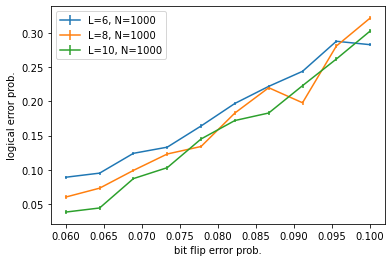

In [824]:
for i_L, L in enumerate(L_list):
    # plt.plot(pz_list,fail_prob_z[i_L,:].T/Nrep,"o-", label="L=%d, N=%d" % (L,Nrep))
    de = np.std(fail_prob_z[i_L,:]/Nrep)/np.sqrt(Nrep-1)
    plt.errorbar(pz_list,fail_prob_z[i_L,:].T/Nrep,de, label="L=%d, N=%d" % (L,Nrep))

# plt.plot(px_list,fail_prob_x.T/Nrep,"x-")
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
plt.legend()
plt.show()

## check logical errors (graphically)

3 [1. 1. 1. 1. 1. 1. 1. 1.]
0 [1. 1. 1. 1. 1. 1. 1. 1.]
1.0 0.0


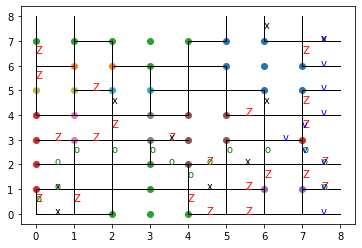

In [901]:
## star stabilizer
def plot_qubit_error(vec,text):
    for i in range(len(vec)):
        if vec[i][0] == 0 :
            ry = vec[i][1] 
            rx = vec[i][2] + 0.5   
        else:
            ry = vec[i][1] + 0.5
            rx = vec[i][2]    
        plt.text(rx,ry,text,color="g")

l = 2
r1 = 8
r2 = r1

# star stabilzers
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

# m = Matching(Sx)

logicals = np.zeros((2,l*r1*r2))
## x ops
logicals[0,1:2*r1+1:2] = np.ones(r2) 
logicals[1,0:l*r1*r2:2*r2] = np.ones(r2) 

# s_h = 0
# count = 0
# while s_h == 0:
    # print(count)
    # count += 1 
# ##### does not work
# percol_check = np.zeros((r1+r2,l*r1*r2))
# for i_r in range(r):
#     percol_check[i_r,(2*i_r*c+1):2*(i_r+1)*c+1:2] = np.ones(c) 
# for i_c in range(c):
#     percol_check[i_c+r,(0+2*i_c):((2*i_c+l*(r-1)*c)+1):2*c] = np.ones(r) 
# # print(np.argwhere(percol_check>0))

# # loss error
prob_l = 0.3 # loss error probability
error_loss = np.random.rand(l*r1*r2) 
loss_inds = np.argwhere(error_loss < prob_l)[:,0]
remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
error_loss[loss_inds] = 1
error_loss[remain_inds] = 0

# print(loss_inds)

# plt.figure(1)
# for i in range(len(loss_inds)):
#     latt_pos = int(loss_inds[i]/2)
#     if loss_inds[i] % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) + 0.5   
#     else:
#         ry = int(latt_pos/r1)  + 0.5 #+0.1
#         rx = (latt_pos%r1)   

#     plt.text(rx,ry,"L",color="b")
# plt.figure(1)
# for i in range(len(remain_inds)):
#     latt_pos = int(remain_inds[i]/2)
#     if remain_inds[i] % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) 
#         plt.plot([rx,rx+1],[ry,ry],color="k")
#     else:
#         ry = int(latt_pos/r1)  
#         rx = (latt_pos%r1)   
#         plt.plot([rx,rx],[ry,ry+1],color="k")

Sx_new = []
inds_new = []
Sx_old = np.copy(Sx)
inds_old = list(range(r1*r2))
for loss_index in loss_inds:
    st_ind = np.argwhere(Sx_old[:,loss_index]>0)
    st_ind = list(st_ind[:,0])
    if len(st_ind)==2:
        inds_new.append(st_ind)
        Stot = np.zeros(l*r1*r2)
        for i_remove in st_ind:
            inds_old.remove(i_remove)
            Stot += Sx_old[i_remove,:]
        Sx_new.append(list(Stot%2)) 
        Sx_old[st_ind,:] = 0
    elif len(st_ind)==1:
        # print(inds_new)
        # print(Sx_new)
        st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
        # print(st_new_ind)
        inds_new[st_new_ind][:] += st_ind
        inds_old.remove(st_ind[0])
        Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
        Sx_old[st_ind,:] = 0
    else:
        # print(loss_index)
        st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
        if len(st_new_ind)>1:
            st_new_ind = list(st_new_ind[:,0])
            # print(st_new_ind)
            # print("current inds: ", inds_new)
            inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
            Stot = np.zeros(l*r1*r2)
            for i_remove in st_new_ind:
                Stot += np.array(Sx_new)[i_remove,:]        
            Sx_new[st_new_ind[0]] = list(Stot%2)
            del inds_new[st_new_ind[1]]
            del Sx_new[st_new_ind[1]]
Sx_new = np.array(Sx_new, dtype=int)
# print(inds_old)
# print(remain_inds)
# print(Sx_old)
# print(inds_new)
# print(Sx_new)

for loss_index in loss_inds:
    st_ind = np.argwhere(Sx_old[:,loss_index]>0)
    st_new_ind = np.argwhere(Sx_old[:,loss_index]>0)
    assert len(st_ind)+len(st_new_ind)==0

color = 1
plt.figure(1)
for s_plaq in inds_new:
    color += 1
    for latt_pos in s_plaq:
        plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

# ##### does not work
# if np.prod(np.dot(error_loss,percol_check[0:r].T)%2) > 0:
#     print("failure y")
# if np.prod(np.dot(error_loss,percol_check[r:-1].T)%2) > 0:
#     print("failure x")

# Sx_broken = np.zeros(r1*r2)
# for i in range(len(loss_inds)):
#     latt_pos = int(loss_inds[i]/2)
#     xy = loss_inds[i]%2
#     Sx_broken[latt_pos] += 1
#     if xy == 0 :
#         latt_pos_2 = (((latt_pos%r1)+1)%r1)+ r1*int(latt_pos/r1)
#         Sx_broken[latt_pos_2] += 1
#     else:
#         latt_pos_2 = (latt_pos%r1)+ r1*((int(latt_pos/r1)+1)%r2)
#         Sx_broken[latt_pos_2] += 1    

# # print(Sx_broken)
# for i in range(len(Sx_broken)):
#     if Sx_broken[i]>0:
#         plt.text((i%r1)-0.05,int(i/r1)+0.05,"%d" % (Sx_broken[i]))

# assert (np.sum(np.dot( rec_x ,  Sx.T) % 2)% 2) == 0
# # assert np.sum(np.dot( rec_tot , np.dot(Λ, Sx.T)) % 2) %2 >0
# np.dot( (rec_x + error_z )%2 , logicals.T) % 2

num_Sx_red = len(inds_new)+len(inds_old)
Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
# print(np.shape(Sx_red[0:len(inds_old),:]),np.shape(Sx_old[np.ix_(inds_old,remain_inds)]))
Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
if len(inds_new)>0:
    Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
Sx_red = Sx_red[:,keep_cols]

qubits_to_plot = remain_inds[keep_cols]
plt.figure(1)
for i in range(len(qubits_to_plot)):
    latt_pos = int(qubits_to_plot[i]/2)
    if qubits_to_plot[i] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) 
        plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
    else:
        ry = int(latt_pos/r1)  
        rx = (latt_pos%r1)   
        plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)
        

overlap = Sx_red.T@Sx_red
inds_to_keep = list(range(np.size(Sx_red,1)))
nl = []
counter = 0
i = 0 
while counter < np.size(Sx_red,1):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
    if len(ovlp_inds)>0:
        # print("edge= ", edge)
        for j in ovlp_inds[::-1,0]:
            # print(inds_to_keep[i+1+j])
            inds_to_keep.remove(inds_to_keep[i+1+j])
        # print(inds_to_keep)
        counter += (len(ovlp_inds)+1)
        nl.append(len(ovlp_inds)+1)
    else:
        counter += 1
        nl.append(1)
    i += 1

# # print(inds_to_keep)  
# # print(nl)
Sx_red_netx = Sx_red[:,inds_to_keep]
remain_qubits = remain_inds[keep_cols[inds_to_keep]]
# print(remain_qubits)
num_edge = len(remain_qubits) #np.size(Sx_red_netx,1)
# # print(num_edge)

nl = np.array(nl)
# print(nl)

# plt.figure(1)
# for i in range(len(remain_qubits)):
#     latt_pos = int(remain_qubits[i]/2)
#     if remain_qubits[i] % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) 
#         plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
#     else:
#         ry = int(latt_pos/r1)  
#         rx = (latt_pos%r1)   
#         plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)

prob_z = 0.2 # error probability
pl = (1-(1-2*prob_z)**nl)/2
error_table = np.random.rand(num_edge) < pl
zflip_inds = np.argwhere(error_table == True)[:,0]
no_zflip_inds = np.argwhere(error_table == False)[:,0]
# error_z = np.random.rand(num_edge) 
# zflip_inds = np.argwhere(error_z < prob_z)[:,0]
# no_zflip_inds = np.argwhere(error_z >= prob_z)[:,0]
error_z = np.zeros(num_edge,dtype=int)
error_z[zflip_inds] = 1
error_z[no_zflip_inds] = 0

plt.figure(1)
for i in range(len(zflip_inds)):
    latt_pos = int(remain_qubits[zflip_inds[i]]/2)
    if remain_qubits[zflip_inds[i]] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   

    plt.text(rx,ry,"Z",color="r")

# # print(np.shape(Sx_red_netx))
# # print(Sx_red_netx.T@Sx_red_netx)

# # # print(Sx_red)
# # print(np.sum(Sx_red,axis=0))
if num_edge > 1:
    # print("logical qubits: ", num_edge-2*Sx_red_netx.shape[0]+2)
    m = Matching(Sx_red_netx,spacelike_weights=np.log((1-pl)/pl))


# find syndrome
syndrome_x = Sx_red_netx@error_z % 2
synd_x_inds = np.argwhere(syndrome_x > 0)
# print(synd_x_inds)
if len(synd_x_inds)>0:
    rec2 = m.decode(syndrome_x)
    rec2_inds = np.argwhere(rec2 > 0)[:,0]
    # print(rec2_inds[:,0])
    plt.figure(1)
    for i in range(len(rec2_inds)):
        latt_pos = int(remain_qubits[rec2_inds[i]]/2)
        if remain_qubits[rec2_inds[i]] % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   

        plt.text(rx,ry,"x",color="k")

# ###########
### logicals
# pos = -1
# if 0 in inds_new[0][:]:
#     v_old = len(inds_old)
# else:
#     v_old = 0

# while pos < (r2-1):
#     print("pos: ", pos)
#     edges = np.argwhere(Sx_red_netx[v_old,:]>0)[:,0]
#     # print(remain_qubits[edges])
#     es_up = edges[np.argwhere(remain_qubits[edges] % 2 > 0)[:,0]]
#     # e_up = es_up[np.argwhere(np.floor(np.floor(remain_qubits[es_up]/2)/r1) > pos)[0,0]]
#     es_up = es_up[np.argwhere(np.floor(np.floor(remain_qubits[es_up]/2)/r1) > pos)[:,0]]
#     print(remain_qubits[es_up])
#     for e_up in es_up:
#         if np.floor(np.floor(remain_qubits[e_up]/2)/r1) - pos < (r2-1):
#             print(remain_qubits[e_up])
#             break
#     pos = int(int(remain_qubits[e_up]/2)/r1)
#     # print(remain_qubits[e_up])

#     latt_pos = int(remain_qubits[e_up]/2)
#     if remain_qubits[e_up] % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) + 0.5   
#     else:
#         ry = int(latt_pos/r1)  + 0.5 
#         rx = (latt_pos%r1)   
#     plt.text(rx,ry,"x",color="k")

#     vs_new = np.argwhere(Sx_red_netx[:,e_up]>0)[:,0] 
#     # print(vs_new)
#     v_new = vs_new[np.argwhere(vs_new != v_old )[0,0]]
#     # print(v_old,v_new)
#     v_old = v_new
#     # pos += 1



# # logicals_red = np.zeros((2,num_edge),dtype=int)
# # l1 = np.arange(1,2*r1+1,2)
# # l2 = np.arange(0,l*r1*r2,2*r2)
# # for i1 in l1:
# #     ind1 = np.argwhere(remain_qubits==i1)
# #     if len(ind1)>0:
# #         logicals_red[0,ind1[0]]=1
# # for i2 in l2:
# #     ind2 = np.argwhere(remain_qubits==i2)
# #     if len(ind2)>0:
# #         logicals_red[1,ind2[0]]=1
# logicals_v = np.zeros((r1,num_edge),dtype=int)
# # missing_v = np.zeros(r1,dtype=int)
# for i1 in range(r1):
#     i_h = np.argwhere(remain_qubits%2 == 0 )[:,0]
#     # print(remain_qubits[i_h])
#     inds = np.argwhere(np.floor(remain_qubits[i_h]/2)%r1 == i1)
#     logicals_v[i1,i_h[inds]]= 1
# #     # missing_v[i1] = (r1 - len(inds)) %2 
# #     if (r1 - len(inds))>0:
# #          missing_v[i1] = 1 


# logicals_h = np.zeros((r2,num_edge),dtype=int)
# # missing_h = np.zeros(r2,dtype=int)
# for i2 in range(r2):
#     i_v = np.argwhere(remain_qubits%2 == 1 )[:,0]
#     inds = np.argwhere(np.floor(np.floor(remain_qubits[i_v]/2)/r1) == i2)
#     logicals_h[i2,i_v[inds]]= 1
#     # missing_h[i2] = (r2 - len(inds)) %2
#     if (r2 - len(inds))>0:
#          missing_h[i2] = 1

# s_h = np.dot( (rec2 + error_z )%2 , logicals_h.T) %2 
# s_v = np.dot( (rec2 + error_z )%2 , logicals_v.T) %2 
# print(s_h, missing_h ) 
# print(s_v, missing_v ) 

# i0_h = np.argwhere(s_h==0)[:,0]
# s_h[i0_h] += missing_h[i0_h]
# i0_v = np.argwhere(s_v==0)[:,0]
# s_v[i0_v] += missing_h[i0_v]

# print(s_h) 
# print(s_v) 

logicals_v = np.zeros((r1,len(qubits_to_plot)),dtype=int)
for i1 in range(r1):
    i_h = np.argwhere(qubits_to_plot%2 == 1 )[:,0]
    inds = np.argwhere(np.floor(qubits_to_plot[i_h]/2)%r1 == i1)
    logicals_v[i1,i_h[inds]]= 1

logicals_h = np.zeros((r2,len(qubits_to_plot)),dtype=int)
for i2 in range(r2):
    i_v = np.argwhere(qubits_to_plot%2 == 0 )[:,0]
    inds = np.argwhere(np.floor(np.floor(qubits_to_plot[i_v]/2)/r1) == i2)
    logicals_h[i2,i_v[inds]]= 1

def horizontal_logic(i2):
    # i2 = int(r2/2)
    i_h = (i2*r1+np.arange(r1))
    logical_h = np.zeros(l*r1*r2)
    i_new_used = np.zeros(len(inds_new),dtype = bool)
    for h_pos in i_h:
        if h_pos in inds_old:
            logical_h += Sx[h_pos,:] 
        else:   
            for i_new in range(len(inds_new)):
                if h_pos in inds_new[i_new] and i_new_used[i_new]==False:
                    logical_h += Sx_new[i_new,:] 
                    i_new_used[i_new] = True

    logical_h = (logical_h% 2)
    ind_logic = np.argwhere(logical_h>0)[:,0]

    for i in range(len(ind_logic)):
        latt_pos = int(ind_logic[i]/2)
        if ind_logic[i] % 2 == 0 :
            ry = int(latt_pos/r1) 
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
        if ry>= i2:
            logical_h[ind_logic[i]] = 0
    return logical_h

def vertical_logic(i1):
    i_v = (i1+r1*np.arange(r2))
    logical_v = np.zeros(l*r1*r2)
    i_new_used = np.zeros(len(inds_new),dtype = bool)
    for v_pos in i_v:
        if v_pos in inds_old:
            logical_v += Sx[v_pos,:] 
        else:   
            for i_new in range(len(inds_new)):
                if v_pos in inds_new[i_new] and i_new_used[i_new]==False:
                    logical_v += Sx_new[i_new,:] 
                    i_new_used[i_new] = True

    logical_v = (logical_v% 2)
    ind_logic = np.argwhere(logical_v>0)[:,0]
    used_inds = np.argwhere(i_new_used==True)[:,0]
    
    for i in range(len(ind_logic)):
        latt_pos = int(ind_logic[i]/2)
        if ind_logic[i] % 2 == 0 :
            rx = (latt_pos%r1) + 0.5   
        else:
            rx = (latt_pos%r1)   
#     if rx>= i1:
        if ((rx-int(r1/2)) % r1) >= ((i1-int(r1/2)) % r1):
            logical_v[ind_logic[i]] = 0
    return logical_v


# i2 = int(r2/2)
# i_h = (i2*r1+np.arange(r1))
# logical_h = np.zeros(l*r1*r2)
# i_new_used = np.zeros(len(inds_new),dtype = bool)
# for h_pos in i_h:
#     ry = int(h_pos/r1) 
#     rx = (h_pos%r1)   
#     if h_pos in inds_old:
#         # plt.text(rx,ry,"x",color="k")
#         logical_h += Sx[h_pos,:] 
#     else:   
#         for i_new in range(len(inds_new)):
#             if h_pos in inds_new[i_new] and i_new_used[i_new]==False:
#                 logical_h += Sx_new[i_new,:] 
#                 i_new_used[i_new] = True

#         # plt.text(rx,ry,"%d" % (h_pos),color="r")

# logical_h = (logical_h% 2)
# ind_logic = np.argwhere(logical_h>0)[:,0]
# # print(ind_logic)

# for i in range(len(ind_logic)):
#     latt_pos = int(ind_logic[i]/2)
#     if ind_logic[i] % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) + 0.5   
#     else:
#         ry = int(latt_pos/r1)  + 0.5 #+0.1
#         rx = (latt_pos%r1)   
#     if ry< i2:
#         plt.text(rx,ry,"o",color="g")
#     else:
#         logical_h[ind_logic[i]] = 0

# i1 = int(r1/2)
# i_v = (i1+r1*np.arange(r2))
# logical_v = np.zeros(l*r1*r2)
# i_new_used = np.zeros(len(inds_new),dtype = bool)
# for v_pos in i_v:
#     ry = int(v_pos/r1) 
#     rx = (v_pos%r1)   
#     if v_pos in inds_old:
#         # plt.text(rx,ry,"x",color="k")
#         logical_v += Sx[v_pos,:] 
#     else:   
#         for i_new in range(len(inds_new)):
#             if v_pos in inds_new[i_new] and i_new_used[i_new]==False:
#                 logical_v += Sx_new[i_new,:] 
#                 i_new_used[i_new] = True

#         # plt.text(rx,ry,"%d" % (v_pos),color="r")

# logical_v = (logical_v% 2)
# ind_logic = np.argwhere(logical_v>0)[:,0]
# # print(ind_logic)

# for i in range(len(ind_logic)):
#     latt_pos = int(ind_logic[i]/2)
#     if ind_logic[i] % 2 == 0 :
#         ry = int(latt_pos/r1) 
#         rx = (latt_pos%r1) + 0.5   
#     else:
#         ry = int(latt_pos/r1)  + 0.5 #+0.1
#         rx = (latt_pos%r1)   
#     if rx< i1:
#         plt.text(rx,ry,"s",color="b")
#     else:
#         logical_v[ind_logic[i]] = 0



check_v = 1
for i2 in range(r2):
    logical_h = horizontal_logic(i2)
    check_h = logical_h[qubits_to_plot]@logicals_v.T % 2
    if np.prod(check_h)>0:
        break

for i1 in range(r1):
    logical_v = vertical_logic(i1)    
    check_v = logical_v[qubits_to_plot]@logicals_h.T % 2
    if np.prod(check_v)>0:
        break

print(i2,check_h)
print(i1,check_v)


inds_logic_h = np.argwhere(logical_h[qubits_to_plot] > 0 )[:,0]
for link in qubits_to_plot[inds_logic_h]:
    latt_pos = int(link/2)
    if link % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   
    plt.text(rx,ry,"o",color="g")

inds_logic_v = np.argwhere(logical_v[qubits_to_plot] > 0 )[:,0]
for link in qubits_to_plot[inds_logic_v]:
    latt_pos = int(link/2)
    if link % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) + 0.5   
    else:
        ry = int(latt_pos/r1)  + 0.5 #+0.1
        rx = (latt_pos%r1)   
    plt.text(rx,ry,"v",color="b")

s_h = np.dot( (rec2 + error_z )%2 , logical_h[remain_qubits].T) %2 
s_v = np.dot( (rec2 + error_z )%2 , logical_v[remain_qubits].T) %2 
print(s_h,s_v)


###############
plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
# plt.grid()
# if s_h > 0:
plt.show()
# else:
#     plt.cla()

## check percolation

0 [1. 1. 1. 1. 1. 1. 1. 1.]
7 [1. 1. 1. 1. 0. 1. 1. 1.]


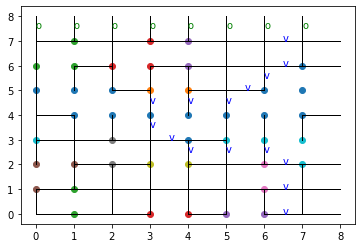

done! iter =  122


In [38]:
l = 2
r1 = 8
r2 = r1

# star stabilzers
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

for count in range(10000):
    # # loss error
    prob_l = 0.2 # loss error probability
    error_loss = np.random.rand(l*r1*r2) 
    loss_inds = np.argwhere(error_loss < prob_l)[:,0]
    remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
    error_loss[loss_inds] = 1
    error_loss[remain_inds] = 0

    Sx_new = []
    inds_new = []
    Sx_old = np.copy(Sx)
    inds_old = list(range(r1*r2))
    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_ind = list(st_ind[:,0])
        if len(st_ind)==2:
            inds_new.append(st_ind)
            Stot = np.zeros(l*r1*r2)
            for i_remove in st_ind:
                inds_old.remove(i_remove)
                Stot += Sx_old[i_remove,:]
            Sx_new.append(list(Stot%2)) 
            Sx_old[st_ind,:] = 0
        elif len(st_ind)==1:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
            inds_new[st_new_ind][:] += st_ind
            inds_old.remove(st_ind[0])
            Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
            Sx_old[st_ind,:] = 0
        else:
            st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
            if len(st_new_ind)>1:
                st_new_ind = list(st_new_ind[:,0])
                inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                Stot = np.zeros(l*r1*r2)
                for i_remove in st_new_ind:
                    Stot += np.array(Sx_new)[i_remove,:]        
                Sx_new[st_new_ind[0]] = list(Stot%2)
                del inds_new[st_new_ind[1]]
                del Sx_new[st_new_ind[1]]
    Sx_new = np.array(Sx_new, dtype=int)

    for loss_index in loss_inds:
        st_ind = np.argwhere(Sx_old[:,loss_index]>0)
        st_new_ind = np.argwhere(Sx_old[:,loss_index]>0)
        assert len(st_ind)+len(st_new_ind)==0

    color = 1
    plt.figure(1)
    for s_plaq in inds_new:
        color += 1
        for latt_pos in s_plaq:
            plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

    num_Sx_red = len(inds_new)+len(inds_old)
    Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
    Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
    if len(inds_new)>0:
        Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

    keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
    Sx_red = Sx_red[:,keep_cols]

    qubits_to_plot = remain_inds[keep_cols]
    plt.figure(1)
    for i in range(len(qubits_to_plot)):
        latt_pos = int(qubits_to_plot[i]/2)
        if qubits_to_plot[i] % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) 
            plt.plot([rx,rx+1],[ry,ry],color="k",linewidth=1)
        else:
            ry = int(latt_pos/r1)  
            rx = (latt_pos%r1)   
            plt.plot([rx,rx],[ry,ry+1],color="k",linewidth=1)

    percolate = False
    logicals_v = np.zeros((r1,len(qubits_to_plot)),dtype=int)
    for i1 in range(r1):
        i_h = np.argwhere(qubits_to_plot%2 == 1 )[:,0]
        inds = np.argwhere(np.floor(qubits_to_plot[i_h]/2)%r1 == i1)
        logicals_v[i1,i_h[inds]]= 1
        if np.sum(logicals_v[i1,:])==0:
            percolate = True

    logicals_h = np.zeros((r2,len(qubits_to_plot)),dtype=int)
    for i2 in range(r2):
        i_v = np.argwhere(qubits_to_plot%2 == 0 )[:,0]
        inds = np.argwhere(np.floor(np.floor(qubits_to_plot[i_v]/2)/r1) == i2)
        logicals_h[i2,i_v[inds]]= 1
        if np.sum(logicals_h[i2,:])==0:
            percolate = True

    def horizontal_logic(i2):
        # i2 = int(r2/2)
        i_h = (i2*r1+np.arange(r1))
        logical_h = np.zeros(l*r1*r2)
        i_new_used = np.zeros(len(inds_new),dtype = bool)
        for h_pos in i_h:
            if h_pos in inds_old:
                logical_h += Sx[h_pos,:] 
            else:   
                for i_new in range(len(inds_new)):
                    if h_pos in inds_new[i_new] and i_new_used[i_new]==False:
                        logical_h += Sx_new[i_new,:] 
                        i_new_used[i_new] = True

        logical_h = (logical_h% 2)
        ind_logic = np.argwhere(logical_h>0)[:,0]

        for i in range(len(ind_logic)):
            latt_pos = int(ind_logic[i]/2)
            if ind_logic[i] % 2 == 0 :
                ry = int(latt_pos/r1) 
            else:
                ry = int(latt_pos/r1)  #+ 0.5 #+0.1
            # if ry>= i2:
            y0 = (i2-int(r2/2))% r2
            if ((ry-y0) % r2) >= ((i2-y0) % r2):
                logical_h[ind_logic[i]] = 0
        return logical_h

    def vertical_logic(i1):
        i_v = (i1+r1*np.arange(r2))
        logical_v = np.zeros(l*r1*r2)
        i_new_used = np.zeros(len(inds_new),dtype = bool)
        for v_pos in i_v:
            if v_pos in inds_old:
                logical_v += Sx[v_pos,:] 
            else:   
                for i_new in range(len(inds_new)):
                    if v_pos in inds_new[i_new] and i_new_used[i_new]==False:
                        logical_v += Sx_new[i_new,:] 
                        i_new_used[i_new] = True

        logical_v = (logical_v% 2)
        ind_logic = np.argwhere(logical_v>0)[:,0]
        used_inds = np.argwhere(i_new_used==True)[:,0]

        for i in range(len(ind_logic)):
            latt_pos = int(ind_logic[i]/2)
            if ind_logic[i] % 2 == 0 :
                rx = (latt_pos%r1) #+ 0.5   
            else:
                rx = (latt_pos%r1)   
            # if rx>= i1:
            x0 = (i1-int(r1/2))% r1
            if ((rx-x0) % r1) >= ((i1-x0) % r1):
                logical_v[ind_logic[i]] = 0
        return logical_v

    for i2 in range(r2):
        logical_h = horizontal_logic(i2)
        check_h = logical_h[qubits_to_plot]@logicals_v.T % 2
        if np.prod(check_h)>0:
            break

    for i1 in range(r1):
        logical_v = vertical_logic(i1)    
        check_v = logical_v[qubits_to_plot]@logicals_h.T % 2
        if np.prod(check_v)>0:
            break

    inds_logic_h = np.argwhere(logical_h[qubits_to_plot] > 0 )[:,0]
    for link in qubits_to_plot[inds_logic_h]:
        latt_pos = int(link/2)
        if link % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   
        plt.text(rx,ry,"o",color="g")

    inds_logic_v = np.argwhere(logical_v[qubits_to_plot] > 0 )[:,0]
    for link in qubits_to_plot[inds_logic_v]:
        latt_pos = int(link/2)
        if link % 2 == 0 :
            ry = int(latt_pos/r1) 
            rx = (latt_pos%r1) + 0.5   
        else:
            ry = int(latt_pos/r1)  + 0.5 #+0.1
            rx = (latt_pos%r1)   
        plt.text(rx,ry,"v",color="b")

    ###############
    plt.xticks(np.arange(0,r1+1.))
    plt.yticks(np.arange(0,r2+1.))
    # plt.grid()
    if (i1 >= r1-1 or i2 >= r2-1) and not percolate:        
        print(i2,check_h)
        print(i1,check_v)
        plt.show()
        break
    else:
        plt.cla()
print("done! iter = ", count)

In [2]:
logicals_v = np.zeros((r1,num_edge),dtype=int)
missing_v = np.zeros(r1,dtype=int)
for i1 in range(r1):
    i_h = np.argwhere(remain_qubits%2 == 0 )[:,0]
    # print(remain_qubits[i_h])
    inds = np.argwhere(np.floor(remain_qubits[i_h]/2)%r1 == i1)
    logicals_v[i1,i_h[inds]]= 1
    # missing_v[i1] = (r1 - len(inds)) %2 
    if (r1 - len(inds))>0:
         missing_v[i1] = 1 


logicals_h = np.zeros((r2,num_edge),dtype=int)
missing_h = np.zeros(r2,dtype=int)
for i2 in range(r2):
    i_v = np.argwhere(remain_qubits%2 == 1 )[:,0]
    inds = np.argwhere(np.floor(np.floor(remain_qubits[i_v]/2)/r1) == i2)
    logicals_h[i2,i_v[inds]]= 1
    # missing_h[i2] = (r2 - len(inds)) %2
    if (r2 - len(inds))>0:
         missing_h[i2] = 1

s_h = np.dot( (rec2 + error_z )%2 , logicals_h.T) %2 
s_v = np.dot( (rec2 + error_z )%2 , logicals_v.T) %2 
print(s_h, missing_h ) 
print(s_v, missing_v ) 

i0_h = np.argwhere(s_h==0)[:,0]
s_h[i0_h] += missing_h[i0_h]
i0_v = np.argwhere(s_v==0)[:,0]
s_v[i0_v] += missing_h[i0_v]

print(s_h) 
print(s_v) 

NameError: name 'r1' is not defined

In [608]:
ypath = []
y0 = 0
inds0 = np.argwhere(remain_qubits%2 == 0)[:,0]
inds1 = np.argwhere(np.floor(np.floor(remain_qubits[inds0]/2)/r1) == y0)[0,0]
# print(remain_qubits[inds0[inds1]])
# x0 = remain_qubits[inds0[inds1]]
# print(x0)
ypath.append(remain_qubits[inds0[inds1]])
i_up = remain_qubits[inds0[inds1]]+ 2*r1
i_left = remain_qubits[inds0[inds1]]+ 1
i_right = remain_qubits[inds0[inds1]]+ 3
if i_up in remain_qubits:
    ypath.append(i_up)
elif i_right in remain_qubits:
    ypath.append(i_right)    
print(ypath)

[2, 18]


## logical operators 

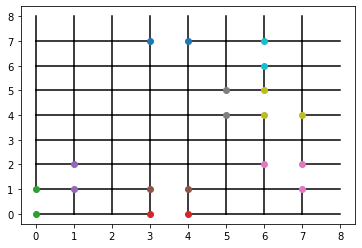

In [466]:
l = 2
r1 = 8
r2 = r1

# star stabilzers
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1

m = Matching(Sx)

logicals = np.zeros((2,l*r1*r2))
## x ops
logicals[0,1:2*r1+1:2] = np.ones(r2) 
logicals[1,0:l*r1*r2:2*r2] = np.ones(r2) 

# loss error
prob_l = 0.08 # loss error probability
error_loss = np.random.rand(l*r1*r2) 
loss_inds = np.argwhere(error_loss < prob_l)[:,0]
remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
error_loss[loss_inds] = 1
error_loss[remain_inds] = 0

plt.figure(1)
for i in range(len(remain_inds)):
    latt_pos = int(remain_inds[i]/2)
    if remain_inds[i] % 2 == 0 :
        ry = int(latt_pos/r1) 
        rx = (latt_pos%r1) 
        plt.plot([rx,rx+1],[ry,ry],color="k")
    else:
        ry = int(latt_pos/r1)  
        rx = (latt_pos%r1)   
        plt.plot([rx,rx],[ry,ry+1],color="k")

Sx_new = []
inds_new = []
Sx_old = np.copy(Sx)
inds_old = list(range(r1*r2))
for loss_index in loss_inds:
    st_ind = np.argwhere(Sx_old[:,loss_index]>0)
    st_ind = list(st_ind[:,0])
    if len(st_ind)==2:
        inds_new.append(st_ind)
        Stot = np.zeros(l*r1*r2)
        for i_remove in st_ind:
            inds_old.remove(i_remove)
            Stot += Sx_old[i_remove,:]
        Sx_new.append(list(Stot%2)) 
        Sx_old[st_ind,:] = 0
    elif len(st_ind)==1:
        # print(inds_new)
        # print(Sx_new)
        st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
        # print(st_new_ind)
        inds_new[st_new_ind][:] += st_ind
        inds_old.remove(st_ind[0])
        Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
        Sx_old[st_ind,:] = 0
    else:
        # print(loss_index)
        st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
        if len(st_new_ind)>1:
            st_new_ind = list(st_new_ind[:,0])
            # print(st_new_ind)
            # print("current inds: ", inds_new)
            inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
            Stot = np.zeros(l*r1*r2)
            for i_remove in st_new_ind:
                Stot += np.array(Sx_new)[i_remove,:]        
            Sx_new[st_new_ind[0]] = list(Stot%2)
            del inds_new[st_new_ind[1]]
            del Sx_new[st_new_ind[1]]
Sx_new = np.array(Sx_new, dtype=int)

for loss_index in loss_inds:
    st_ind = np.argwhere(Sx_old[:,loss_index]>0)
    st_new_ind = np.argwhere(Sx_old[:,loss_index]>0)
    assert len(st_ind)+len(st_new_ind)==0

color = 1
for s_plaq in inds_new:
    color += 1
    for latt_pos in s_plaq:
        plt.plot((latt_pos%r1),int(latt_pos/r1),"o",color="C%d" % (color))

num_Sx_red = len(inds_new)+len(inds_old)
Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
# print(np.shape(Sx_red[0:len(inds_old),:]),np.shape(Sx_old[np.ix_(inds_old,remain_inds)]))
Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
if len(inds_new)>0:
    Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
Sx_red = Sx_red[:,keep_cols]

# print(np.shape(Sx_red))
# print(Sx_red.T@Sx_red)

overlap = Sx_red.T@Sx_red
inds_to_keep = list(range(np.size(Sx_red,1)))
nl = []
counter = 0
i = 0 
while counter < np.size(Sx_red,1):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
    if len(ovlp_inds)>0:
        # print("edge= ", edge)
        for j in ovlp_inds[::-1,0]:
            # print(inds_to_keep[i+1+j])
            inds_to_keep.remove(inds_to_keep[i+1+j])
        # print(inds_to_keep)
        counter += (len(ovlp_inds)+1)
        nl.append(len(ovlp_inds)+1)
    else:
        counter += 1
        nl.append(1)
    i += 1

Sx_red_netx = Sx_red[:,inds_to_keep]
remain_qubits = remain_inds[keep_cols[inds_to_keep]]
# print(remain_qubits)
num_edge = len(remain_qubits) #np.size(Sx_red_netx,1)
# print(num_edge)

nl = np.array(nl)
# print(nl)
pl = (1-(1-2*prob_z)**nl)/2

if num_edge > 1:
    # print("logical qubits: ", num_edge-2*Sx_red_netx.shape[0]+2)
    m = Matching(Sx_red_netx,spacelike_weights=np.log((1-pl)/pl))
# ###########

plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
# plt.grid()
plt.show()

logicals_v = np.zeros((r1,num_edge),dtype=int)
for i1 in range(r1):
    i_h = np.argwhere(remain_qubits%2 == 0 )[:,0]
    # print(remain_qubits[i_h])
    inds = np.argwhere(np.floor(remain_qubits[i_h]/2)%r1 == i1)
    logicals_v[i1,i_h[inds]]= 1

logicals_h = np.zeros((r2,num_edge),dtype=int)
for i2 in range(r2):
    i_v = np.argwhere(remain_qubits%2 == 1 )[:,0]
    inds = np.argwhere(np.floor(np.floor(remain_qubits[i_v]/2)/r1) == i2)
    logicals_h[i2,i_v[inds]]= 1


# print(np.dot( (rec2 + error_z )%2 , logicals_h.T) %2 ) 
# print(np.dot( (rec2 + error_z )%2 , logicals_v.T) %2 ) 




# check via plotting

In [193]:
from pymatching import Matching

"""
Each column of Hz corresponds to an X error on a qubit, and each
row corresponds to a Z stabiliser.

Hz[i,j]==1 if Z stabiliser i acts non-trivially
on qubit j, and is 0 otherwise.
"""
Hz = np.array([
    [1,1,0,0,0],
    [0,1,1,0,0],
    [0,0,1,1,0],
    [0,0,0,1,1]
])

plist = np.random.rand(5)
m = Matching(Hz,spacelike_weights=np.log((plist)/plist))
m

<pymatching.Matching object with 4 detectors, 1 boundary node, and 5 edges>

In [194]:
noise = np.array([0,0,1,1,0])
z = Hz@noise % 2
c = m.decode(z)
print("c: {}, of type {}".format(c, type(c)))

c: [0 0 1 1 0], of type <class 'numpy.ndarray'>


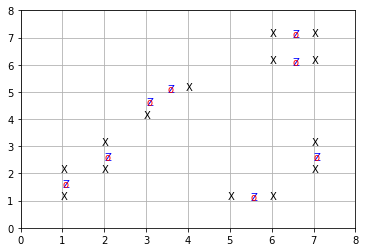

In [93]:
# star stabilzers
l = 2
r1 = 8
r2 = 8
Sx = np.zeros((r1*r2,l*r1*r2),dtype=int)
for i_y in range(r2):
    for i_x in range(r1):
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
        Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
        Sx[i_y*r1 + i_x, 2*(((i_y-1)%r1)*r1+i_x)+1] = 1
m = Matching(Sx)

# z flip error
pz = 0.05 # error probability
zflip = np.random.rand(l,r1,r2) 
zflip_inds = np.argwhere(zflip < pz)
error_z = np.zeros(l*r1*r2)
for i in range(len(zflip_inds)):
    error_z[zflip_inds[i][0]+2*(zflip_inds[i][1]*r1+zflip_inds[i][2])] = 1
plt.figure(1)
for i in range(len(zflip_inds)):
    if zflip_inds[i][0] == 0 :
        ry = zflip_inds[i][1] 
        rx = zflip_inds[i][2] + 0.5   
    else:
        ry = zflip_inds[i][1] + 0.5 #+0.1
        rx = zflip_inds[i][2]    

    plt.text(rx,ry,"Z",color="b")


# find syndrome
syndrome_x = Sx@error_z % 2
synd_x_inds = np.argwhere(syndrome_x > 0)
# print(synd_x_inds)
plt.figure(1)
for i in range(len(synd_x_inds)):
    plt.text((synd_x_inds[i][0]%r1)-0.05,int(synd_x_inds[i][0]/r1)+0.05,'X')
    
rec2 = m.decode(syndrome_x)
rec2_inds = np.argwhere(rec2 > 0)
for i in range(len(rec2_inds)):
    rec2_pos = int(rec2_inds[i]/2)
    if rec2_inds[i] % 2 == 0 :
        ry = int(rec2_pos/r1) 
        rx = (rec2_pos%r1) + 0.5   
    else:
        ry = int(rec2_pos/r1)  + 0.5 #+0.1
        rx = (rec2_pos%r1)
        
    plt.text(rx,ry,"o",color="r")


    
plt.xticks(np.arange(0,r1+1.))
plt.yticks(np.arange(0,r2+1.))
plt.grid()
plt.show()

